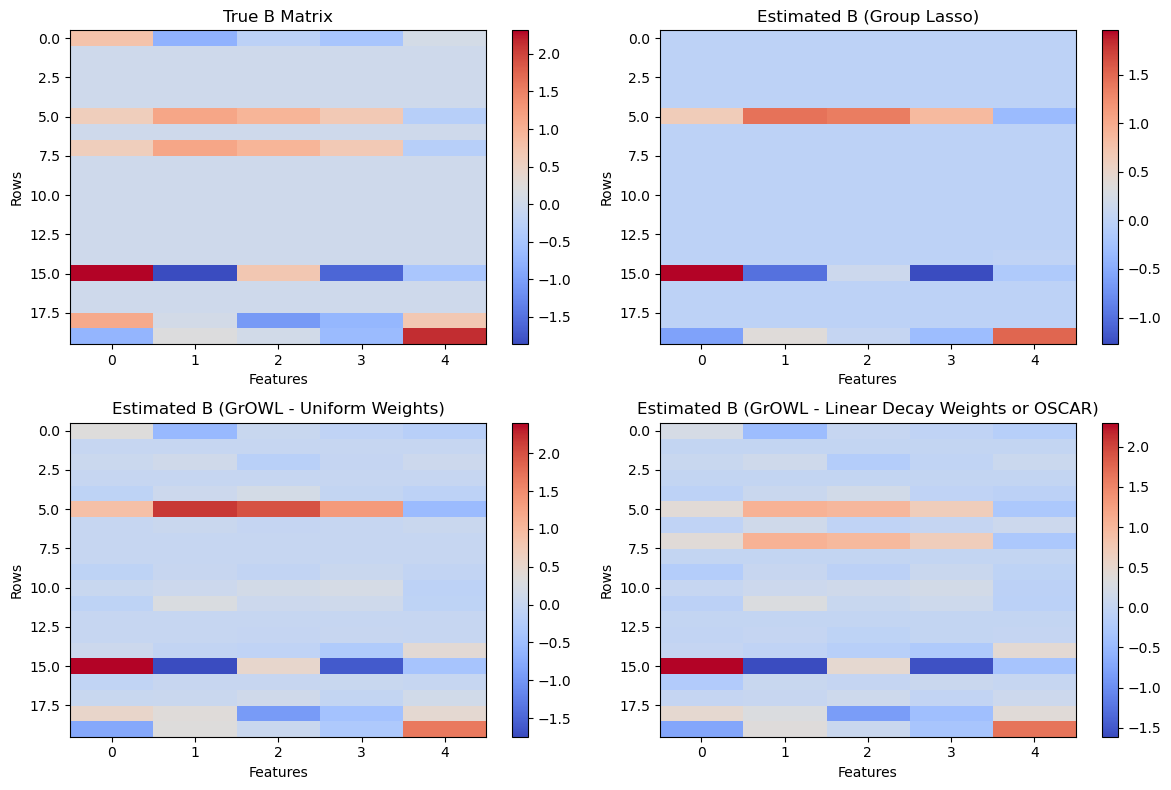

MultiTaskLasso cost = 9.150574636341839
GrOWL LASSO cost = 13.396242358993696


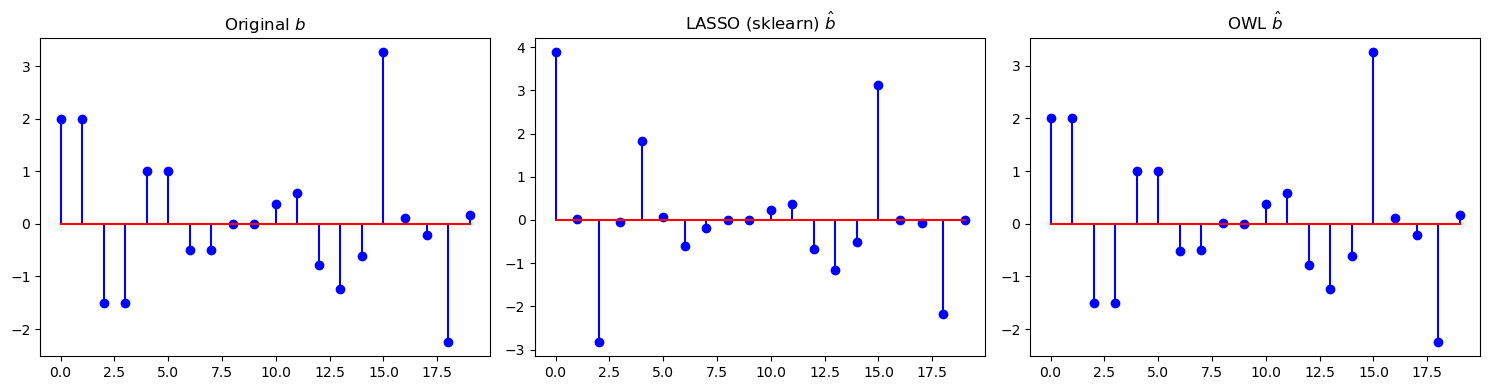

In [25]:
import numpy as np

def prox_owl(v, w):
    """
    Calculates the proximal operator for the OWL norm on vectors. Given a 
    vector v and sorted non-increasing weights w, computes the OWL proximal 
    operator, given by 

        prox_{\Omega_w}(v) = argmin_x (1/2) || x - v ||_2^2 + \Omega_w(x),
 
    where Omega_w(x) = \sum_i w_i |x|_(i) is the OWL norm, and w is of the same
    dimension as x and sorted in non-increasing order: w_1 >= ... >= w_p >= 0. 
    Also |x|_(i) are the components of v reordered in non-increasing order (by
    absolute value).

    The solution of the min problem is given in equation (24) of the paper
    "The ordered weighted L1 norm - atomic formulation, projections, and 
    Algorithms" by Zeng and M. Figueiredo (2015). It relies on the following
    algorithm:

    1. Sorting |v| in descending order to get |v|_(i).
    2. Performing thresholding with w: compute z_i = max(|v|_(i) - w_i, 0).
    3. Applying an isotonic regression step to ensure the result remains
       non-increasing when ordered by absolute value.
    4. Restoring the original order and signs of v.

    The method ensures that the sparsity and ordering properties of the OWL
    norm are preserved, which generalizes the soft-thresholding operator used 
    in Lasso to a structured penalization framework.

    Args:
        v (np.ndarray): Input vector.
        w (np.ndarray): Non-increasing sequence of weights.

    Returns:
        np.ndarray: The result of applying the OWL proximal operator to v.
    """
    
    # 1. Sort |v| in descending order, keep track of the sort index
    abs_v = np.abs(v)
    sort_idx = np.argsort(-abs_v) # indices that would sort abs_v in descending
                                  # order
    abs_v_sorted = abs_v[sort_idx]

    # 2. Apply Pool Adjacent Violators (PAV) algorithm for isotonic regression

    # Step 1: z_i = abs_v_sorted[i] - w[i], then sort z in descending order if
    # needed
    z = abs_v_sorted - w
    # Step 2: the "pool adjacent violators" for z in descending order
    #         ensuring the final vector is sorted and each entry >= 0
    z_proj = np.zeros_like(z)
    start = 0
    while start < len(z):
        end = start
        # average the block [start, end] if any negativity or non-increasing 
        # violation arises
        block_sum = z[start]
        while end + 1 < len(z) and z[end+1] > z[end]:
            end += 1
            block_sum += z[end]
        
        # block is from start to end
        avg = block_sum / (end - start + 1)
        for j in range(start, end + 1):
            z_proj[j] = max(avg, 0)
        start = end + 1

    # Now we have a "sorted" version z_proj for the absolute values. Re-map to 
    # v using sort_idx. Then, restore signs:
    v_sorted = z_proj
    v_final = np.zeros_like(v)
    for i in range(len(v)):
        idx = sort_idx[i]
        v_final[idx] = np.sign(v[idx]) * v_sorted[i]

    return v_final

def prox_growl(V, w):
    """
    Calculates proximal operator given by 
    
       prx_G(V) = argmin_B (1/2)||B - V||_F^2 + sum_i w_i ||\beta_{i\cdot}||_2,
    
    given that w is sorted in non-increasing order (w_1 >= ... >= w_p >= 0).
    """
    p, r = V.shape
    # Compute row norms
    row_norms = np.linalg.norm(V, axis=1)

    # If a row is zero, we keep it zero (to avoid dividing by zero).
    # So handle those carefully.
    # Step 1: compute the prox for the row norms via the OWL prox
    shrunk_row_norms = prox_owl(row_norms, w)
    # Step 2: rescale each row
    out = np.zeros_like(V)
    for i in range(p):
        norm_i = row_norms[i]
        if norm_i > 0:
            out[i, :] = (shrunk_row_norms[i] / norm_i) * V[i, :]
        else:
            out[i, :] = V[i, :]
            
    return out

def growl(X, Y, w=None, weight_type=None, lambda_1=1.0, lambda_2=0.5,
          ramp_size=1, ramp_delta=1.0, max_iter=1000, tol=1e-8):
    """
    Solve the GrOWL-regularized least-squares problem:

        min_B ||Y - X B||_F^2  +  sum_i w_i || \beta_{i, \cdot} ||_2

    using a FISTA-type proximal splitting scheme.

    By default, the user can pass in a custom `w` (length-p array, 
    non-negative, non-increasing). Alternatively, set `weight_type` 
    to one of ['lasso', 'linear', 'spike', 'ramp'] to build `w` 
    automatically from `lambda_1`, `lambda_2`, `ramp_size`, and `ramp_delta`. 

    The four predefined weight types are:

    1. Lasso:
       w_i = lambda_1  for  i = 1, ..., p

    2. Linear (OSCAR style):
       w_i = lambda_1 + lambda_2 * (p - i) / p 
       i = 1, ..., p  (largest at i=0, smallest at i=p-1)

    3. Spike:
       w_1 = lambda_1 + lambda_2 for i = 1;
       w_i = lambda_1            for i = 2, ..., p

    4. Ramp:
       For i = 1, ..., ramp_size:
           w_i = (ramp_size - i + 1)*ramp_delta + lambda_1
       For i = ramp_size + 1, ..., p:
           w_i = lambda_1

    Args:
        X : (n x p) numpy array
        Y : (n x r) numpy array
        w : (p,) array of non-negative, non-increasing weights (Optional)
        weight_type : str in ['lasso', 'linear', 'spike', 'ramp'] (Optional)
        lambda_1 : float, used in all four weight definitions above
        lambda_2 : float, used in 'linear' and 'spike'
        ramp_size: int, used in 'ramp'
        ramp_delta: float, used in 'ramp'
        max_iter : maximum number of FISTA iterations
        tol : tolerance for stopping criterion

    Returns:
        B : (p x r) numpy array, the solution estimate.
        cost_hist : list of cost function values across iterations

    Note:
        If both `w` and `weight_type` are provided, an error is raised.
        If neither is provided, an error is also raised.
    """

    # Ensure Y is a matrix with one column if it is a vector
    if Y.ndim == 1:
        Y = Y[:, None]  

    # First, validate arguments
    if w is not None and weight_type is not None:
        raise ValueError(
            "Please provide either `w` (a custom weight vector) or "
            "`weight_type` (one of 'lasso', 'linear', 'spike', 'ramp'), "
            "but not both."
        )
        
    n, p = X.shape
    _, r = Y.shape

    # If the user has chosen a predefined weight type, build w accordingly
    if weight_type is not None:
        w = np.zeros(p, dtype=float)
        if weight_type.lower() == 'lasso':
            # 1) Lasso
            w[:] = lambda_1
        elif weight_type.lower() == 'linear':
            # 2) Linear
            w = lambda_1 + lambda_2*(np.arange(p)[::-1] / p)
            # w[i] = lambda_1 + lambda_2 * (p-1 - i)/p
            #for i in range(p):
            #    w[i] = lambda_1 + lambda_2 * (p - 1 - i)/p
        elif weight_type.lower() == 'spike':
            # 3) Spike
            w[0] = lambda_1 + lambda_2
            w[1:] = lambda_1
        elif weight_type.lower() == 'ramp':
            # 4) Ramp
            # w[i] = (ramp_size - i)*ramp_delta + lambda_1 for i < ramp_size
            # w[i] = lambda_1 for i >= ramp_size
            for i in range(p):
                if i < ramp_size:
                    w[i] = (ramp_size - i) * ramp_delta + lambda_1
                else:
                    w[i] = lambda_1
        else:
            raise ValueError(f"Invalid weight_type: {weight_type}. "
                             "Choose from ['lasso', 'linear', 'spike', 'ramp'].")
        
        # Ensure non-increasing sort if needed
        # (These formulas are already in non-increasing order if lambda_2 >= 0, ramp_delta >= 0)
        # But just to be safe, we can sort descending:
        w = np.sort(w)[::-1]

    elif w is None:
        raise ValueError(
            "You must provide either a custom `w` or specify a `weight_type`."
        )

    # Lipschitz constant L for the gradient of f(B) = ||Y - X B||^2
    # The gradient is 2 X^T(X B - Y). So L = 2*spectral_norm(X^T X) = 2||X||^2
    # A simpler upper bound is 2 * (largest eigenvalue of X^T X). 
    # We can estimate or compute directly via power method:
    # L = 2 * np.linalg.norm(X, 2)**2
    L = 2 * (np.linalg.norm(X, 2)**2)

    # Initialize
    B = np.zeros((p, r))
    Z = B.copy()
    t = 1.0

    cost_hist = []

    def cost_function(B_):
        # f(B) = ||Y - X B||_F^2
        # g(B) = sum_i w_i ||\beta_{i, \cdot}||_2
        residual = Y - X @ B_
        fval = np.sum(residual**2) # Perform square Frobenius norm
        row_norms_ = np.linalg.norm(B_, axis=1)
        # Sort row_norms_ in descending order and multiply by w (assumed
        # sorted) to match sum_i w_i || \beta_{i·}||_2 with sorted row norms
        sorted_norms = np.sort(row_norms_)[::-1]  # descending
        gval = np.sum(w * sorted_norms)
        return fval + gval

    for it in range(max_iter):
        B_old = B.copy()

        # Gradient step on Z
        grad_f_Z = 2.0 * X.T @ (X @ Z - Y) # shape: (p, r)
        # Update with step size 1/L
        V = Z - (1 / L) * grad_f_Z  # shape: (p, r)

        # Prox step
        B = prox_growl(V, (1.0/L)*w)  # scale weights by (1/L)
    
        # FISTA update (Nesterov momentum step)
        t_new = 0.5 * (1.0 + np.sqrt(1.0 + 4.0 * t * t))
        Z = B + ((t - 1.0) / t_new) * (B - B_old)
        t = t_new

        # Check stopping criterion
        cost_val = cost_function(B)
        cost_hist.append(cost_val)

        # Optionally check norm difference or cost difference
        if it > 0 and np.abs(cost_hist[-2] - cost_hist[-1]) < tol:
            break

    return B, cost_hist

if __name__ == "__main__":

    import matplotlib.pyplot as plt
    from sklearn.linear_model import MultiTaskLasso

    ############################### GrOWL example #############################
    
    # Simulate a toy example where two columns in X are highly correlated
    np.random.seed(42)
    n, p, r = 10, 20, 5  # n<p to highlight Group Lasso limitation
    X = np.random.randn(n, p)
    # Create high correlation between columns 5 and 7:
    X[:, 5] = X[:, 7] + 0.01 * np.random.randn(n) 
    
    # True B matrix with sparsity
    B_true_toy = np.zeros((p, r))
    B_true_toy[5, :] = np.random.randn(r)  
    # Mimic correlation by setting equal coefficients for column 7:
    B_true_toy[7, :] = B_true_toy[5, :]  
    # Add random coefficients to row 0:
    B_true_toy[0, :] = np.random.randn(r)  
    # Add random coefficients to row 3:
    B_true_toy[15, :] = np.random.randn(r)
    # Add random coefficients to row 2
    B_true_toy[18, :] = np.random.randn(r)  
    # Add random coefficients to row 8
    B_true_toy[p-1, :] = np.random.randn(r)  

    # for i in range(p):
    #     if i != 5 and i != 7:
    #         B_true_toy[i, :] = np.random.randn(r)
    
    # Generate Y from X and B_true_toy
    Y_toy = X @ B_true_toy + 0.3 * np.random.randn(n, r)
    
    # Estimate B using different weights
    B_est_toy, cost_hist_toy = growl(X, Y_toy, weight_type='lasso')
    B_est_linear, cost_hist_linear = growl(X, Y_toy, weight_type='linear')
    B_est_spike, cost_hist_spike = growl(X, Y_toy, weight_type='spike')
    B_est_ramp, cost_hist_ramp = growl(X, Y_toy, weight_type='ramp')

    # Apply Group Lasso using sklearn's MultiTaskLasso
    lasso_model = MultiTaskLasso(alpha=1, fit_intercept=False, max_iter=1000)
    lasso_model.fit(X, Y_toy)
    B_est_lasso = lasso_model.coef_.T  # Coefficients estimated by Group Lasso    

    # Visual comparison between real B and estimates
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # True B matrix
    im1 = axes[0, 0].imshow(B_true_toy, cmap='coolwarm', aspect='auto')
    axes[0, 0].set_title("True B Matrix")
    axes[0, 0].set_xlabel("Features")
    axes[0, 0].set_ylabel("Rows")
    fig.colorbar(im1, ax=axes[0, 0])
    
    # Estimated B matrix (Group Lasso)
    im2 = axes[0, 1].imshow(B_est_lasso, cmap='coolwarm', aspect='auto')
    axes[0, 1].set_title("Estimated B (Group Lasso)")
    axes[0, 1].set_xlabel("Features")
    axes[0, 1].set_ylabel("Rows")
    fig.colorbar(im2, ax=axes[0, 1])
    
    # Estimated B matrix (GrOWL - Uniform Weights)
    im3 = axes[1, 0].imshow(B_est_toy, cmap='coolwarm', aspect='auto')
    axes[1, 0].set_title("Estimated B (GrOWL - Uniform Weights)")
    axes[1, 0].set_xlabel("Features")
    axes[1, 0].set_ylabel("Rows")
    fig.colorbar(im3, ax=axes[1, 0])
    
    # Estimated B matrix (GrOWL - Linear Decay Weights)
    im4 = axes[1, 1].imshow(B_est_linear, cmap='coolwarm', aspect='auto')
    axes[1, 1].set_title("Estimated B (GrOWL - Linear Decay Weights or OSCAR)")
    axes[1, 1].set_xlabel("Features")
    axes[1, 1].set_ylabel("Rows")
    fig.colorbar(im4, ax=axes[1, 1])

    # # Estimated B matrix (GrOWL - Spike Weights)
    # im5 = axes[2, 0].imshow(B_est_ramp, cmap='coolwarm', aspect='auto')
    # axes[2, 0].set_title("Estimated B (GrOWL - Ramp Weights)")
    # axes[2, 0].set_xlabel("Features")
    # axes[2, 0].set_ylabel("Rows")
    # fig.colorbar(im5, ax=axes[2, 0])

    # # Estimated B matrix (GrOWL - Ramp Weights)
    # im6 = axes[2, 1].imshow(B_est_spike, cmap='coolwarm', aspect='auto')
    # axes[2, 1].set_title("Estimated B (GrOWL - Spike Weights)")
    # axes[2, 1].set_xlabel("Features")
    # axes[2, 1].set_ylabel("Rows")
    # fig.colorbar(im6, ax=axes[2, 1])
    
    plt.tight_layout()
    plt.show()

    
    # COMPARES ERRORS BETWEEN IMPLEMENTATIONS OF GLASSO
    W = lasso_model.coef_.T  # shape (p, r)
    residual = Y_toy - X @ W  # shape (n, r)
    mse_term = 0.5 / X.shape[0] * np.sum(residual**2)
    
    # Sum of row norms
    row_norms = np.linalg.norm(W, axis=1)  # shape (p,)
    penalty_term = 1 * np.sum(row_norms)
    
    cost_value = mse_term + penalty_term
    print("MultiTaskLasso cost =", cost_value)
    print("GrOWL LASSO cost =", cost_hist_toy[-1])


    ############################### OWL example #############################

    np.random.seed(46)

    n = 100
    p = 20

    X_base = np.random.randn(n, p)

    X = X_base.copy()
    X[:, 1] = X[:, 0] + 0.02 * np.random.randn(n)
    X[:, 3] = X[:, 2] + 0.01 * np.random.randn(n)
    X[:, 4] = X[:, 5] + 0.02 * np.random.randn(n)
    X[:, 6] = X[:, 7] + 0.07 * np.random.randn(n)
  
    #X[:, 7] = X[:, 6] + 0.5 * np.random.randn(n)

    #b_true = np.zeros(p)
    b_true = np.random.randn(p)
    b_true[0:2] = 2.0
    b_true[2:4] = -1.5
    b_true[4:6] = 1
    b_true[6:8] = -0.5
    b_true[8] = 0
    b_true[9] = 0
    
    y = X @ b_true + 0.05 * np.random.randn(n)
    #Y = y[:, None]

    w = np.linspace(1.0, 0.2, p)
    w = np.sort(w)[::-1]

    B_hat_owl, _ = growl(X, Y, w=w, max_iter=2000, tol=1e-7)
    b_hat_owl = B_hat_owl.ravel()

    lasso_sklearn = Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)
    lasso_sklearn.fit(X, y)
    b_hat_lasso_sklearn = lasso_sklearn.coef_

    w_lasso = np.ones(p)
    B_hat_lasso, _ = growl(X, y, w=w_lasso, max_iter=2000, tol=1e-7)
    b_hat_lasso = B_hat_lasso.ravel()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.stem(b_true, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("Original $b$")

    plt.subplot(1, 3, 2)
    plt.stem(b_hat_lasso_sklearn, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("LASSO (sklearn) $\hat{b}$")

    # plt.subplot(1, 3, 3)
    # plt.stem(b_hat_lasso, linefmt="b-", markerfmt="bo", basefmt="r-")
    # plt.title("LASSO (my code) $̂{x}$")

    plt.subplot(1, 3, 3)
    plt.stem(b_hat_owl, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("OWL $\hat{b}$")

    plt.tight_layout()
    plt.show()

Another test

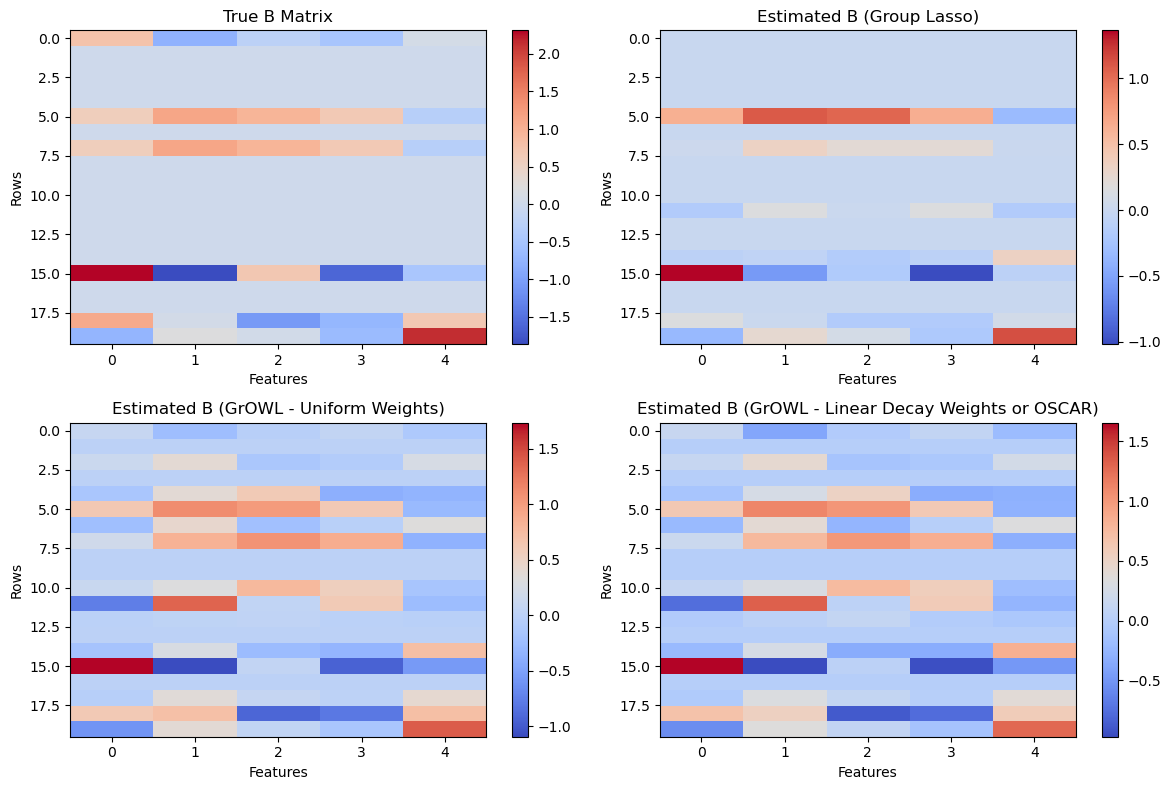

MultiTaskLasso cost = 10.111417979769023
GrOWL LASSO cost = 16.152886026579406


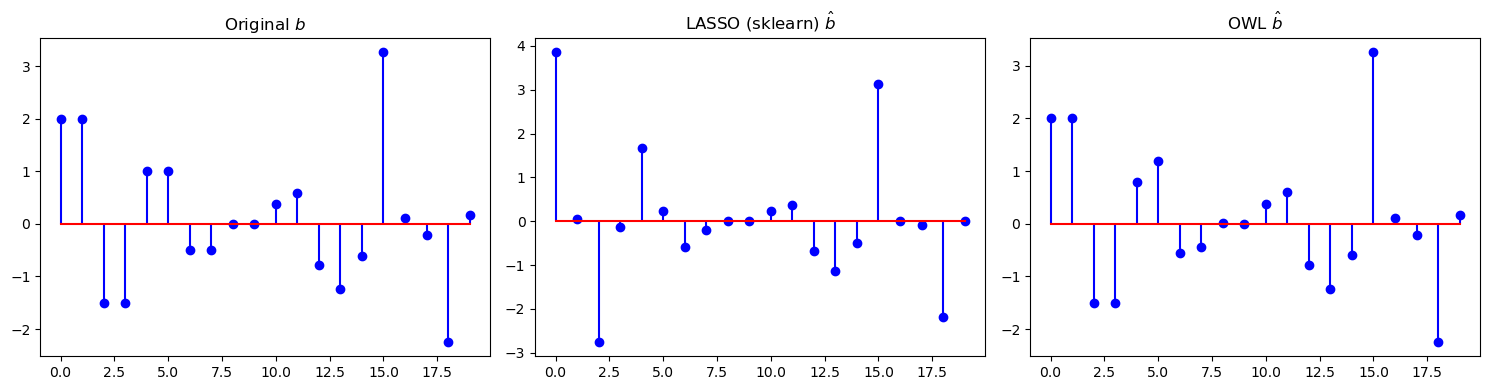

In [19]:
import numpy as np

def prox_owl(v, w):
    """
    Calculates the proximal operator for the OWL norm on vectors. Given a 
    vector v and sorted non-increasing weights w, computes the OWL proximal 
    operator, given by 

        prox_{\Omega_w}(v) = argmin_x (1/2) || x - v ||_2^2 + \Omega_w(x),
 
    where Omega_w(x) = \sum_i w_i |x|_(i) is the OWL norm, and w is of the same
    dimension as x and sorted in non-increasing order: w_1 >= ... >= w_p >= 0. 
    Also |x|_(i) are the components of v reordered in non-increasing order (by
    absolute value).

    The solution of the min problem is given in equation (24) of the paper
    "The ordered weighted L1 norm - atomic formulation, projections, and 
    Algorithms" by Zeng and M. Figueiredo (2015). It relies on the following
    algorithm:

    1. Sorting |v| in descending order to get |v|_(i).
    2. Performing thresholding with w: compute z_i = max(|v|_(i) - w_i, 0).
    3. Applying an isotonic regression step to ensure the result remains
       non-increasing when ordered by absolute value.
    4. Restoring the original order and signs of v.

    The method ensures that the sparsity and ordering properties of the OWL
    norm are preserved, which generalizes the soft-thresholding operator used 
    in Lasso to a structured penalization framework.

    Args:
        v (np.ndarray): Input vector.
        w (np.ndarray): Non-increasing sequence of weights.

    Returns:
        np.ndarray: The result of applying the OWL proximal operator to v.
    """
    
    # 1. Sort |v| in descending order, keep track of the sort index
    abs_v = np.abs(v)
    sort_idx = np.argsort(-abs_v) # indices that would sort abs_v in descending
                                  # order
    abs_v_sorted = abs_v[sort_idx]

    # 2. Apply Pool Adjacent Violators (PAV) algorithm for isotonic regression

    # Step 1: z_i = abs_v_sorted[i] - w[i], then sort z in descending order if
    # needed
    z = abs_v_sorted - w
    # Step 2: the "pool adjacent violators" for z in descending order
    #         ensuring the final vector is sorted and each entry >= 0
    z_proj = np.zeros_like(z)
    start = 0
    while start < len(z):
        end = start
        # average the block [start, end] if any negativity or non-increasing 
        # violation arises
        block_sum = z[start]
        while end + 1 < len(z) and z[end+1] > z[end]:
            end += 1
            block_sum += z[end]
        
        # block is from start to end
        avg = block_sum / (end - start + 1)
        for j in range(start, end + 1):
            z_proj[j] = max(avg, 0)
        start = end + 1

    # Now we have a "sorted" version z_proj for the absolute values. Re-map to 
    # v using sort_idx. Then, restore signs:
    v_sorted = z_proj
    v_final = np.zeros_like(v)
    for i in range(len(v)):
        idx = sort_idx[i]
        v_final[idx] = np.sign(v[idx]) * v_sorted[i]

    return v_final

def prox_growl(V, w):
    """
    Calculates proximal operator given by 
    
       prx_G(V) = argmin_B (1/2)||B - V||_F^2 + sum_i w_i ||\beta_{i\cdot}||_2,
    
    given that w is sorted in non-increasing order (w_1 >= ... >= w_p >= 0).
    """
    p, r = V.shape
    # Compute row norms
    row_norms = np.linalg.norm(V, axis=1)

    # If a row is zero, we keep it zero (to avoid dividing by zero).
    # So handle those carefully.
    # Step 1: compute the prox for the row norms via the OWL prox
    shrunk_row_norms = prox_owl(row_norms, w)
    # Step 2: rescale each row
    out = np.zeros_like(V)
    for i in range(p):
        norm_i = row_norms[i]
        if norm_i > 0:
            out[i, :] = (shrunk_row_norms[i] / norm_i) * V[i, :]
        else:
            out[i, :] = V[i, :]
            
    return out

def growl(X, Y, w=None, weight_type=None, lambda_1=1.0, lambda_2=0.5,
          ramp_size=1, ramp_delta=1.0, max_iter=1000, tol=1e-8):
    """
    Solve the GrOWL-regularized least-squares problem:

        min_B ||Y - X B||_F^2  +  sum_i w_i || \beta_{i, \cdot} ||_2

    using a FISTA-type proximal splitting scheme.

    By default, the user can pass in a custom `w` (length-p array, 
    non-negative, non-increasing). Alternatively, set `weight_type` 
    to one of ['lasso', 'linear', 'spike', 'ramp'] to build `w` 
    automatically from `lambda_1`, `lambda_2`, `ramp_size`, and `ramp_delta`. 

    The four predefined weight types are:

    1. Lasso:
       w_i = lambda_1  for  i = 1, ..., p

    2. Linear (OSCAR style):
       w_i = lambda_1 + lambda_2 * (p - i) / p 
       i = 1, ..., p  (largest at i=0, smallest at i=p-1)

    3. Spike:
       w_1 = lambda_1 + lambda_2 for i = 1;
       w_i = lambda_1            for i = 2, ..., p

    4. Ramp:
       For i = 1, ..., ramp_size:
           w_i = (ramp_size - i + 1)*ramp_delta + lambda_1
       For i = ramp_size + 1, ..., p:
           w_i = lambda_1

    Args:
        X : (n x p) numpy array
        Y : (n x r) numpy array
        w : (p,) array of non-negative, non-increasing weights (Optional)
        weight_type : str in ['lasso', 'linear', 'spike', 'ramp'] (Optional)
        lambda_1 : float, used in all four weight definitions above
        lambda_2 : float, used in 'linear' and 'spike'
        ramp_size: int, used in 'ramp'
        ramp_delta: float, used in 'ramp'
        max_iter : maximum number of FISTA iterations
        tol : tolerance for stopping criterion

    Returns:
        B : (p x r) numpy array, the solution estimate.
        cost_hist : list of cost function values across iterations

    Note:
        If both `w` and `weight_type` are provided, an error is raised.
        If neither is provided, an error is also raised.
    """

    # Ensure Y is a matrix with one column if it is a vector
    if Y.ndim == 1:
        Y = Y[:, None]  

    # First, validate arguments
    if w is not None and weight_type is not None:
        raise ValueError(
            "Please provide either `w` (a custom weight vector) or "
            "`weight_type` (one of 'lasso', 'linear', 'spike', 'ramp'), "
            "but not both."
        )
        
    n, p = X.shape
    _, r = Y.shape

    # If the user has chosen a predefined weight type, build w accordingly
    if weight_type is not None:
        w = np.zeros(p, dtype=float)
        if weight_type.lower() == 'lasso':
            # 1) Lasso
            w[:] = lambda_1
        elif weight_type.lower() == 'linear':
            # 2) Linear
            w = lambda_1 + lambda_2*(np.arange(p)[::-1] / p)
            # w[i] = lambda_1 + lambda_2 * (p-1 - i)/p
            #for i in range(p):
            #    w[i] = lambda_1 + lambda_2 * (p - 1 - i)/p
        elif weight_type.lower() == 'spike':
            # 3) Spike
            w[0] = lambda_1 + lambda_2
            w[1:] = lambda_1
        elif weight_type.lower() == 'ramp':
            # 4) Ramp
            # w[i] = (ramp_size - i)*ramp_delta + lambda_1 for i < ramp_size
            # w[i] = lambda_1 for i >= ramp_size
            for i in range(p):
                if i < ramp_size:
                    w[i] = (ramp_size - i) * ramp_delta + lambda_1
                else:
                    w[i] = lambda_1
        else:
            raise ValueError(f"Invalid weight_type: {weight_type}. "
                             "Choose from ['lasso', 'linear', 'spike', 'ramp'].")
        
        # Ensure non-increasing sort if needed
        # (These formulas are already in non-increasing order if lambda_2 >= 0, ramp_delta >= 0)
        # But just to be safe, we can sort descending:
        w = np.sort(w)[::-1]

    elif w is None:
        raise ValueError(
            "You must provide either a custom `w` or specify a `weight_type`."
        )

    # Lipschitz constant L for the gradient of f(B) = ||Y - X B||^2
    # The gradient is 2 X^T(X B - Y). So L = 2*spectral_norm(X^T X) = 2||X||^2
    # A simpler upper bound is 2 * (largest eigenvalue of X^T X). 
    # We can estimate or compute directly via power method:
    # L = 2 * np.linalg.norm(X, 2)**2
    L = 2 * (np.linalg.norm(X, 2)**2)

    # Initialize
    B = np.zeros((p, r))
    Z = B.copy()
    t = 1.0

    cost_hist = []

    def cost_function(B_):
        # f(B) = ||Y - X B||_F^2
        # g(B) = sum_i w_i ||\beta_{i, \cdot}||_2
        residual = Y - X @ B_
        fval = np.sum(residual**2) # Perform square Frobenius norm
        row_norms_ = np.linalg.norm(B_, axis=1)
        # Sort row_norms_ in descending order and multiply by w (assumed
        # sorted) to match sum_i w_i || \beta_{i·}||_2 with sorted row norms
        sorted_norms = np.sort(row_norms_)[::-1]  # descending
        gval = np.sum(w * sorted_norms)
        return fval + gval

    for it in range(max_iter):
        B_old = B.copy()

        # Gradient step on Z
        grad_f_Z = 2.0 * X.T @ (X @ Z - Y) # shape: (p, r)
        # Update with step size 1/L
        V = Z - (1 / L) * grad_f_Z  # shape: (p, r)

        # Prox step
        B = prox_growl(V, (1.0/L)*w)  # scale weights by (1/L)
    
        # FISTA update (Nesterov momentum step)
        t_new = 0.5 * (1.0 + np.sqrt(1.0 + 4.0 * t * t))
        Z = B + ((t - 1.0) / t_new) * (B - B_old)
        t = t_new

        # Check stopping criterion
        cost_val = cost_function(B)
        cost_hist.append(cost_val)

        # Optionally check norm difference or cost difference
        if it > 0 and np.abs(cost_hist[-2] - cost_hist[-1]) < tol:
            break

    return B, cost_hist

if __name__ == "__main__":

    import matplotlib.pyplot as plt
    from sklearn.linear_model import MultiTaskLasso

    ############################### GrOWL example #############################
    
    # Simulate a toy example where two columns in X are highly correlated
    np.random.seed(42)
    n, p, r = 10, 20, 5  # n<p to highlight Group Lasso limitation
    X = np.random.randn(n, p)
    # Create high correlation between columns 5 and 7:
    X[:, 5] = X[:, 7] + 10 * np.random.randn(n) 
    
    # True B matrix with sparsity
    B_true_toy = np.zeros((p, r))
    B_true_toy[5, :] = np.random.randn(r)  
    # Mimic correlation by setting equal coefficients for column 7:
    B_true_toy[7, :] = B_true_toy[5, :] 
    # Add random coefficients to row 0:
    B_true_toy[0, :] = np.random.randn(r)  
    # Add random coefficients to row 3:
    B_true_toy[15, :] = np.random.randn(r)
    # Add random coefficients to row 2
    B_true_toy[18, :] = np.random.randn(r)  
    # Add random coefficients to row 8
    B_true_toy[p-1, :] = np.random.randn(r)  

    # for i in range(p):
    #     if i != 5 and i != 7:
    #         B_true_toy[i, :] = np.random.randn(r)
    
    # Generate Y from X and B_true_toy
    Y_toy = X @ B_true_toy + 0.9 * np.random.randn(n, r)
    
    # Estimate B using different weights
    B_est_toy, cost_hist_toy = growl(X, Y_toy, weight_type='lasso')
    B_est_linear, cost_hist_linear = growl(X, Y_toy, weight_type='linear')
    B_est_spike, cost_hist_spike = growl(X, Y_toy, weight_type='spike')
    B_est_ramp, cost_hist_ramp = growl(X, Y_toy, weight_type='ramp')

    # Apply Group Lasso using sklearn's MultiTaskLasso
    lasso_model = MultiTaskLasso(alpha=1, fit_intercept=False, max_iter=1000)
    lasso_model.fit(X, Y_toy)
    B_est_lasso = lasso_model.coef_.T  # Coefficients estimated by Group Lasso    

    # Visual comparison between real B and estimates
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # True B matrix
    im1 = axes[0, 0].imshow(B_true_toy, cmap='coolwarm', aspect='auto')
    axes[0, 0].set_title("True B Matrix")
    axes[0, 0].set_xlabel("Features")
    axes[0, 0].set_ylabel("Rows")
    fig.colorbar(im1, ax=axes[0, 0])
    
    # Estimated B matrix (Group Lasso)
    im2 = axes[0, 1].imshow(B_est_lasso, cmap='coolwarm', aspect='auto')
    axes[0, 1].set_title("Estimated B (Group Lasso)")
    axes[0, 1].set_xlabel("Features")
    axes[0, 1].set_ylabel("Rows")
    fig.colorbar(im2, ax=axes[0, 1])
    
    # Estimated B matrix (GrOWL - Uniform Weights)
    im3 = axes[1, 0].imshow(B_est_toy, cmap='coolwarm', aspect='auto')
    axes[1, 0].set_title("Estimated B (GrOWL - Uniform Weights)")
    axes[1, 0].set_xlabel("Features")
    axes[1, 0].set_ylabel("Rows")
    fig.colorbar(im3, ax=axes[1, 0])
    
    # Estimated B matrix (GrOWL - Linear Decay Weights)
    im4 = axes[1, 1].imshow(B_est_linear, cmap='coolwarm', aspect='auto')
    axes[1, 1].set_title("Estimated B (GrOWL - Linear Decay Weights or OSCAR)")
    axes[1, 1].set_xlabel("Features")
    axes[1, 1].set_ylabel("Rows")
    fig.colorbar(im4, ax=axes[1, 1])

    # # Estimated B matrix (GrOWL - Spike Weights)
    # im5 = axes[2, 0].imshow(B_est_ramp, cmap='coolwarm', aspect='auto')
    # axes[2, 0].set_title("Estimated B (GrOWL - Ramp Weights)")
    # axes[2, 0].set_xlabel("Features")
    # axes[2, 0].set_ylabel("Rows")
    # fig.colorbar(im5, ax=axes[2, 0])

    # # Estimated B matrix (GrOWL - Ramp Weights)
    # im6 = axes[2, 1].imshow(B_est_spike, cmap='coolwarm', aspect='auto')
    # axes[2, 1].set_title("Estimated B (GrOWL - Spike Weights)")
    # axes[2, 1].set_xlabel("Features")
    # axes[2, 1].set_ylabel("Rows")
    # fig.colorbar(im6, ax=axes[2, 1])
    
    plt.tight_layout()
    plt.show()

    
    # COMPARES ERRORS BETWEEN IMPLEMENTATIONS OF GLASSO
    W = lasso_model.coef_.T  # shape (p, r)
    residual = Y_toy - X @ W  # shape (n, r)
    mse_term = 0.5 / X.shape[0] * np.sum(residual**2)
    
    # Sum of row norms
    row_norms = np.linalg.norm(W, axis=1)  # shape (p,)
    penalty_term = 1 * np.sum(row_norms)
    
    cost_value = mse_term + penalty_term
    print("MultiTaskLasso cost =", cost_value)
    print("GrOWL LASSO cost =", cost_hist_toy[-1])


    ############################### OWL example #############################
    from sklearn.linear_model import Lasso
    
    np.random.seed(46)

    n = 100
    p = 20

    X_base = np.random.randn(n, p)

    X = X_base.copy()
    X[:, 1] = X[:, 0] + 0.02 * np.random.randn(n)
    X[:, 3] = X[:, 2] + 0.01 * np.random.randn(n)
    X[:, 4] = X[:, 5] + 0.02 * np.random.randn(n)
    X[:, 6] = X[:, 7] + 0.07 * np.random.randn(n)
  
    #X[:, 7] = X[:, 6] + 0.5 * np.random.randn(n)

    #b_true = np.zeros(p)
    b_true = np.random.randn(p)
    b_true[0:2] = 2.0
    b_true[2:4] = -1.5
    b_true[4:6] = 1
    b_true[6:8] = -0.5
    b_true[8] = 0
    b_true[9] = 0
    
    y = X @ b_true + 0.1 * np.random.randn(n)
    #Y = y[:, None]

    w = np.linspace(1.0, 0.2, p)
    w = np.sort(w)[::-1]

    B_hat_owl, _ = growl(X, y, w=w, max_iter=2000, tol=1e-7)
    b_hat_owl = B_hat_owl.ravel()

    lasso_sklearn = Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)
    lasso_sklearn.fit(X, y)
    b_hat_lasso_sklearn = lasso_sklearn.coef_

    w_lasso = np.ones(p)
    B_hat_lasso, _ = growl(X, y, w=w_lasso, max_iter=2000, tol=1e-7)
    b_hat_lasso = B_hat_lasso.ravel()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.stem(b_true, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("Original $b$")

    plt.subplot(1, 3, 2)
    plt.stem(b_hat_lasso_sklearn, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("LASSO (sklearn) $\hat{b}$")

    # plt.subplot(1, 3, 3)
    # plt.stem(b_hat_lasso, linefmt="b-", markerfmt="bo", basefmt="r-")
    # plt.title("LASSO (my code) $̂{x}$")

    plt.subplot(1, 3, 3)
    plt.stem(b_hat_owl, linefmt="b-", markerfmt="bo", basefmt="r-")
    plt.title("OWL $\hat{b}$")

    plt.tight_layout()
    plt.show()